# Generation of Kinematically Consistent Motion Primitives

This notebook demonstrates the underlying mechanics of generating motion primitives used in the State Lattice graph. We focus on short trajectories (based on cubic curvature polynomials) that ensure smooth transitions between states.

> **Note:** For a deeper dive into the generator implementation and examples, please refer to the [CubicPrimitivesGenerator repository](https://github.com/PathPlanning/CubicPrimitivesGenerator).

We will cover:
1.  **Theta Discretization:** How continuous angles are mapped to a discrete set.
2.  **Online Generation:** Visualizing Newton's method for finding path parameters.
3.  **Curvature Constraints:** Justifying the simplification of zero curvature ($\kappa=0$) at graph nodes.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline  

import sys
sys.path.append("../common/")
from KC_structs import *
from KC_graphics import *
from trajectory_optimization import optimization_Newton 

## 1. Discrete Heading Angles ($\theta$)

In a State Lattice planner, the continuous heading angle of the robot is discretized into a finite set of directions (e.g., 16 or 32). This allows us to represent the robot's configuration $(x, y, \theta)$ as a discrete state in a graph.

The plot below visualizes a 16-angle discretization. Each arrow represents a valid heading direction for a node in the graph.

In [2]:
theta_16 = Theta()  # fix discretization

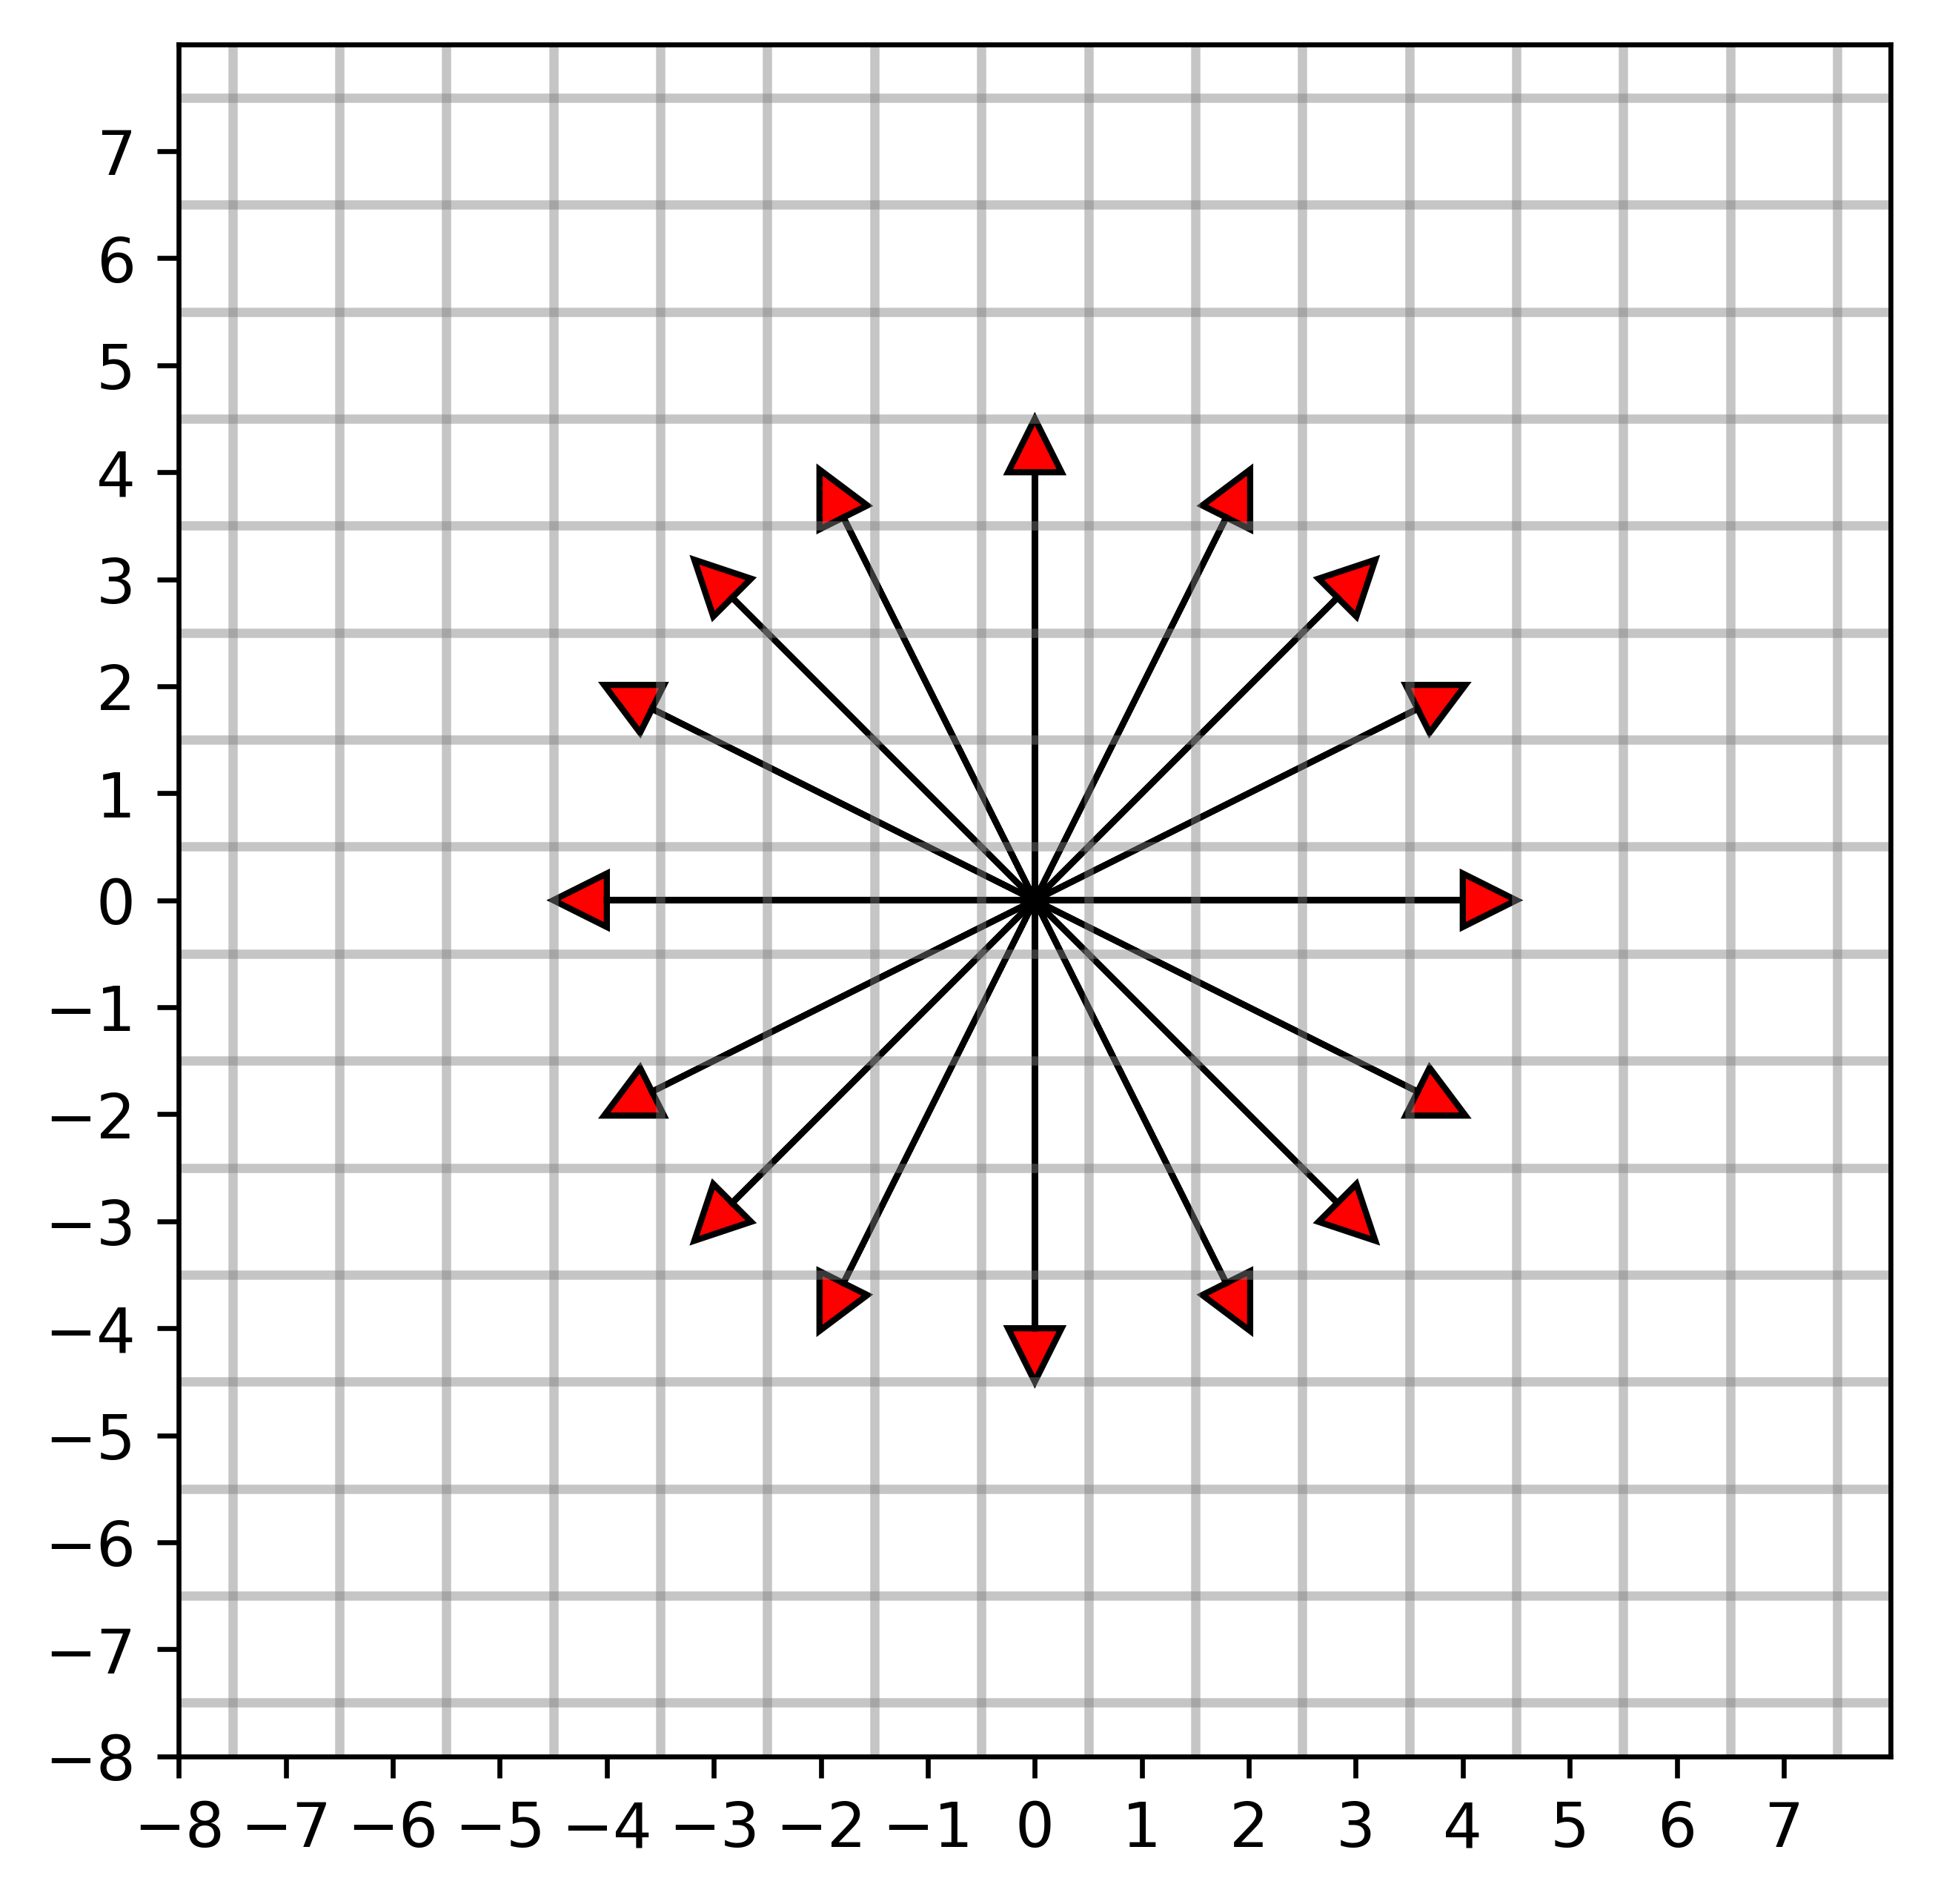

In [16]:
# Cell 1 Code
fig = plt.figure(figsize=(5, 5), dpi=600)
ax = fig.add_subplot(111)

for i in range(16):
    # Assuming theta_16 is defined in your imports or setup
    plot_arrow(0, 0, theta_16[i], length=4, ax=ax)
    
draw_grid(ax)

# plt.savefig("../../images/theta_diskr.png", transparent=False, facecolor='white')
plt.show()

## 2. Online Trajectory Generation

Generating a primitive involves solving a **Two-Point Boundary Value Problem (BVP)**. We need to find a curve connecting the start state $(x_s, y_s, \theta_s)$ and the goal state $(x_g, y_g, \theta_g)$.

We use a numerical optimization approach (Newton's method) to find the parameters of a cubic curvature polynomial that satisfies these boundary conditions. The animation below demonstrates how the trajectory "relaxes" into the correct shape over several iterations.

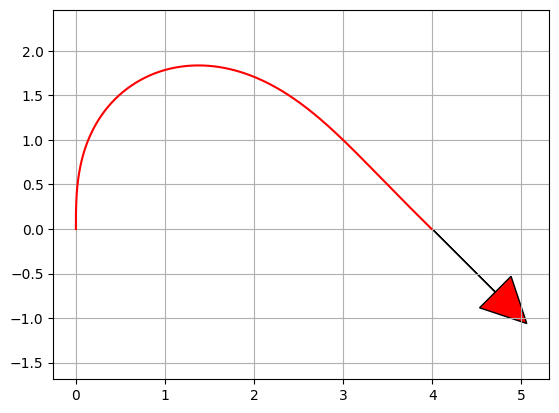

203


In [7]:
start = State(0, 0, np.pi/2)
target = State(4, 0, -np.pi/4)
steps, traj = optimization_Newton(start, target, redraw_trajectory=redraw_trajectory)
print(steps)

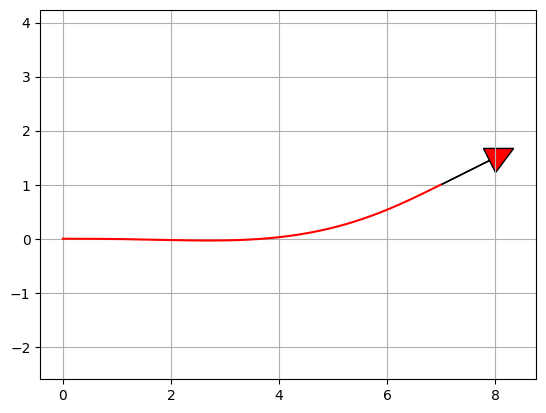

In [8]:
start = State(0,0,0)
target = State(7,1,theta_16[1])
steps, traj = optimization_Newton(start, target, redraw_trajectory=redraw_trajectory)

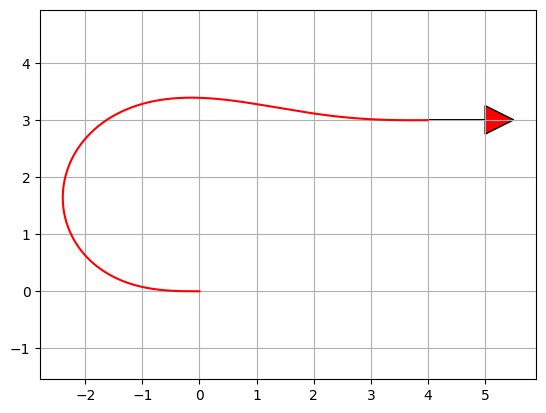

In [9]:
start = State(0, 0, np.pi)
target = State(4, 3, 0)
steps, traj = optimization_Newton(start, target, redraw_trajectory=redraw_trajectory)

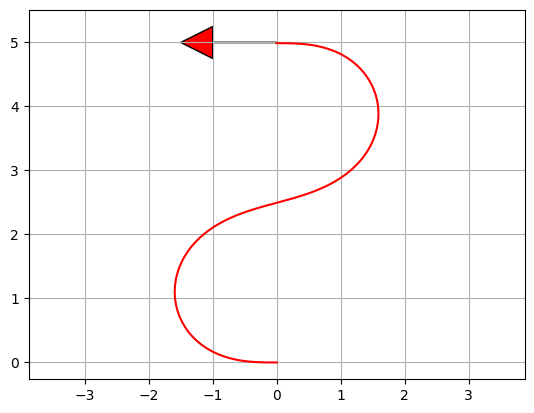

In [10]:
start = State(0, 0, np.pi)
target = State(0, 5, np.pi)
steps, traj = optimization_Newton(start, target, redraw_trajectory=redraw_trajectory)

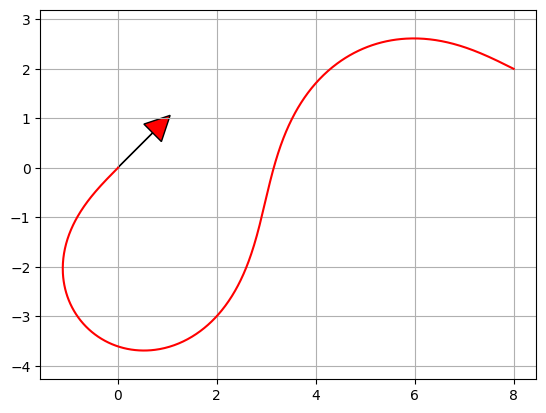

In [11]:
target = State(0, 0, np.deg2rad(2 / 16 * 360))
start = State(x=8.0, y=2.0, theta=np.arctan(2) + 3 * np.pi/2 - np.pi)
steps, traj = optimization_Newton(start, target, redraw_trajectory=redraw_trajectory)

## 3. The "Flattened" Circle: Justifying Zero-Curvature Constraints

A key optimization in our State Lattice implementation is restricting the curvature $\kappa$ to be **zero** at the start and end of every motion primitive.

### Why do we do this?
If we allowed arbitrary curvature at the nodes, the state vector would increase from $(x, y, \theta)$ to $(x, y, \theta, \kappa)$. This would exponentially increase the size of the search graph (the "curse of dimensionality"), making A* search significantly slower.

### Does it hurt trajectory quality?
By enforcing $\kappa=0$ at nodes, we cannot represent a perfect circle (constant non-zero curvature). Instead, a turn is represented as a sequence of curves where curvature starts at 0, peaks, and returns to 0.

The comparison below shows:
1.  **Left:** A perfect circle (constant curvature).
2.  **Center:** A 90-degree turn generated by our solver with boundary conditions $\kappa_{start}=0, \kappa_{end}=0$.
3.  **Right:** A "Squashed Circle" constructed from four such primitives (red) overlaid on the perfect circle (blue dashed).

**Conclusion:** As seen in the rightmost plot, the geometric discrepancy is minimal. The "squashed" trajectory effectively approximates the circular motion while keeping the search space low-dimensional and efficient.

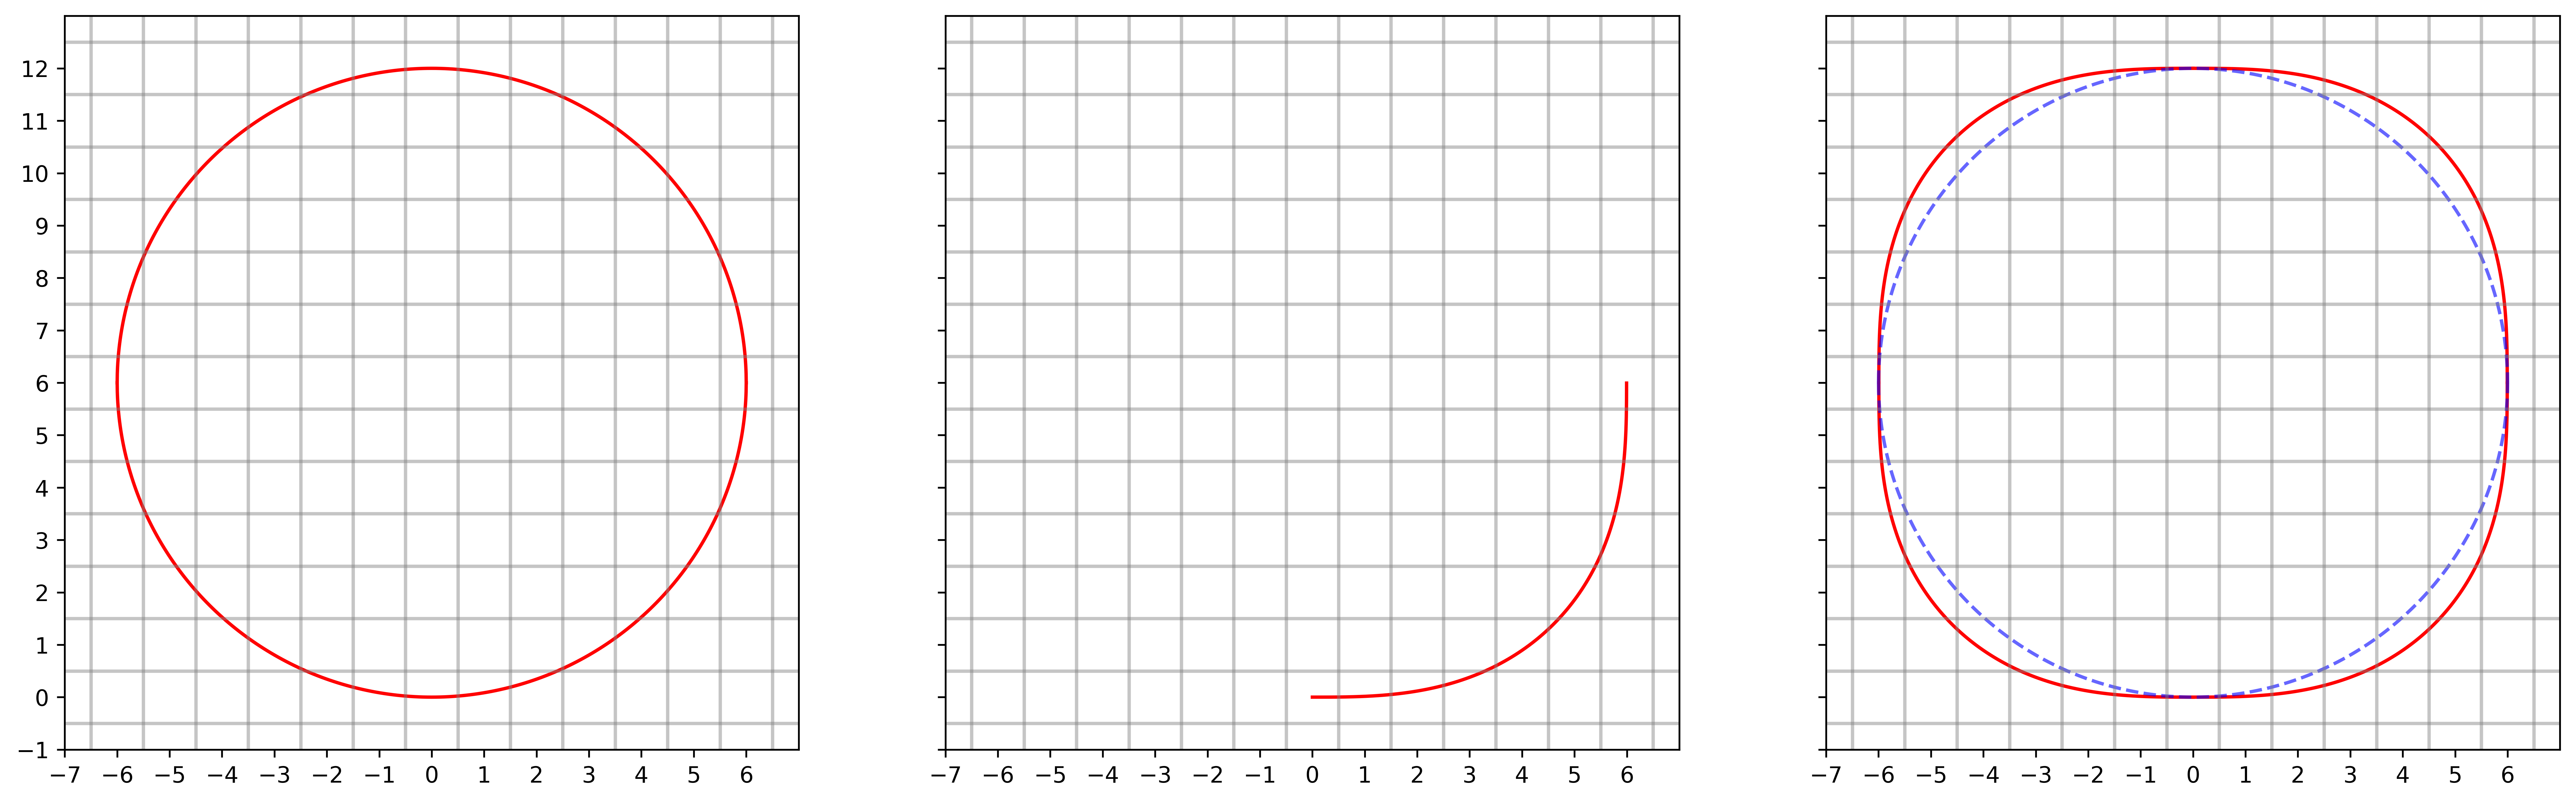

In [19]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6), dpi=600, sharex=False, sharey=True)

r = 6  # Circle radius

# 1. Draw a perfect circle (composed of upper and lower semicircles)
x = np.linspace(-r, r, 5000)  
y = np.sqrt(r ** 2 - x ** 2)  # Semicircle equation: y = sqrt(r^2 - x^2)

# Plot upper and lower halves on the first axis
# We add +r to shift the graph so the lowest point is at (0,0)
axs[0].plot(x, y + r, color='red')
axs[0].plot(x, -y + r, color='red') 
xo, yo = x, y  # Save coordinates for comparison later

# 2. Draw a single primitive (quarter-turn) with zero start/end curvature
start = State(0, 0, 0)
target = State(r, r, np.pi/2)
steps, traj = optimization_Newton(start, target)

# Visualize the single trajectory on the second axis
show_trajectory(traj, ax=axs[1], arrow=False)

# 3. Construct the "Squashed Circle" by chaining 4 primitives
x = traj.sample_x()
y = traj.sample_y()

# Plot the 4 segments by shifting and mirroring the coordinates
axs[2].plot(x, y, color='red')
axs[2].plot(x, -y + 2 * r, color='red')
axs[2].plot(-x, y, color='red')
axs[2].plot(-x, -y + 2 * r, color='red')

# Overlay the perfect circle (dashed blue line) for comparison
axs[2].plot(xo, yo + r, color='blue', ls="--", alpha=0.6)
axs[2].plot(xo, -yo + r, color='blue', ls="--", alpha=0.6)

# Draw grids for context (representing the discrete workspace)
# Adjust bounds as needed based on the radius
draw_grid(axs[0], xs=-7, xf=7, ys=-1, yf=14-1)  
draw_grid(axs[1], xs=-7, xf=7, ys=-1, yf=14-1)
draw_grid(axs[2], xs=-7, xf=7, ys=-1, yf=14-1)

# Optional: Save the figure to the 'images' folder
# plt.savefig("../../images/circ_and_zero.png", transparent=False, facecolor='white')
plt.show()